In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

from results.revision.revision_utils import BM_DIR, DATA_PATH
from utils.serialization_ops import load_pickle

patient_dataset = load_pickle(DATA_PATH)

AD /AR patient

In [2]:
import pandas as pd
import mlflow

from utils.serialization_ops import load_pickle
from results.revision.revision_utils import *

mlflow.set_tracking_uri(TRACKING_URI)
path = mlflow.artifacts.download_artifacts(
    FOLD_RESULTS_PICKLE.format(run_id=RUN_ASC3_W_RANKNET)
)
fold_results = load_pickle(path)

benchmark_ids = get_snv_only_case(patient_dataset[fold_results["test_ids"][4]])
test_dataset = patient_dataset[benchmark_ids]

disease_df = pd.read_csv(DISEASE_DATA, sep="\t", compression="gzip")
disease2inheriance = disease_df.set_index("#omimPhenoId")["inheritances:value"].to_dict()

ad_patients = get_patient_with_inheritance(test_dataset, disease2inheriance, pattern="autosomal dominant")
ar_patients = get_patient_with_inheritance(test_dataset, disease2inheriance, pattern="autosomal recessive")

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import tqdm
from benchmark.parse_exomiser_files import ExomiserOutputParser
from benchmark.parse_lirical_files import LiricalOutputParser

exomiser_dir = os.path.join(BM_DIR, "exomiser")
exomiser_dfs = dict()
exomiser = ExomiserOutputParser(exomiser_dir)
for patient in tqdm.tqdm(ad_patients):
    sample_id = patient.sample_id
    try:
        exomiser_dfs[sample_id] = exomiser.parse_variant(sample_id, inheritance="AD")
    except:
        continue

lirical_dir = exomiser_dir.replace("exomiser", "lirical")
lirical_dfs = dict()
lirical = LiricalOutputParser(lirical_dir)
for patient in tqdm.tqdm(ad_patients):
    sample_id = patient.sample_id
    try:
        lirical_dfs[sample_id] = lirical.parse(sample_id)
    except:
        continue
    
common_sample_ids = list(exomiser_dfs.keys() & lirical_dfs.keys())

100%|██████████| 545/545 [00:03<00:00, 178.24it/s]


In [4]:
import numpy as np
import tqdm
from core.metric import topk_recall
from results.revision.revision_utils import benchmark_exomsier, benchmark_tool_topk

ks = [1, 2, 3, 4, 5, 10, 20, 50, 100]

performance_exomiser = np.zeros(shape=(len(ks), len(common_sample_ids)))
performance_lricial = np.zeros_like(performance_exomiser)
performance_3asc = np.zeros_like(performance_exomiser)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fold = 5
for k_idx, k in tqdm.tqdm(enumerate(ks)):
    for sample_idx, sample_id in enumerate(common_sample_ids):
        casual_variants = [variant_disease[0] for variant_disease in test_dataset[sample_id].snv_data.causal_variant]
        performance_exomiser[k_idx, sample_idx] = benchmark_exomsier(exomiser_dfs[sample_id], casual_variants, k=k, score_col="variant_score")
        performance_lricial[k_idx, sample_idx] = benchmark_tool_topk(lirical_dfs[sample_id], casual_variants, k=k)
        
        n_snv = patient_dataset[sample_id].snv_data.x.shape[0]
        
        res_idx = fold_results["test_ids"][fold-1].index(sample_id)
        probs = fold_results["fold_instance_y_probs"][fold-1][res_idx]
        labels = fold_results["fold_instance_y_trues"][fold-1][res_idx]
        performance_3asc[k_idx, sample_idx] = topk_recall(probs, labels, k=k)

9it [00:09,  1.08s/it]


In [5]:
lirical_topk = performance_lricial.mean(axis=1)
exomiser_topk = performance_exomiser.mean(axis=1)
asc3_topk = performance_3asc.mean(axis=1)

print(lirical_topk)
print(exomiser_topk)
print(asc3_topk)

[0.4971537  0.49905123 0.50094877 0.5028463  0.50664137 0.52182163
 0.5540797  0.62049336 0.94497154]
[0.56736243 0.62618596 0.64895636 0.66982922 0.68121442 0.77229602
 0.87476281 0.9373814  0.94686907]
[0.71157495 0.87096774 0.91840607 0.95825427 0.96774194 0.98102467
 0.99240987 0.99620493 0.99620493]


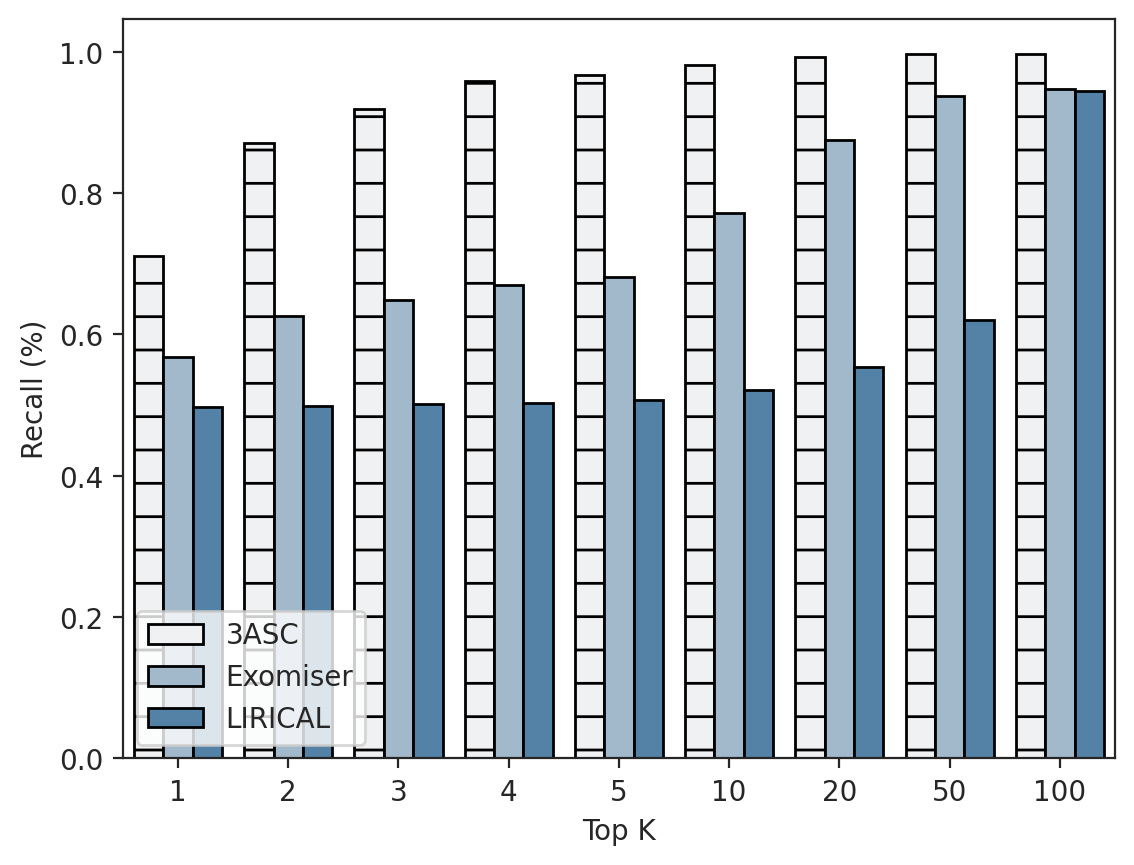

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# sns.set_context('paper')
# sns.set_color_codes('pastel')
sns.set_style("ticks")
figure_data = pd.DataFrame(
    {
        "topk": exomiser_topk.tolist() + asc3_topk.tolist() + lirical_topk.tolist(),
        "Tool": ["Exomiser"] * len(exomiser_topk) + ["3ASC"] * len(asc3_topk) + ["LIRICAL"] * len(lirical_topk),
        "rank": ks * 3,
    }
)

sns.color_palette("Paired")
legend_order = ["3ASC", "Exomiser", "LIRICAL"]
fig, axes = plt.subplots(dpi=200)
bar = sns.barplot(
    figure_data, 
    x="rank", 
    y="topk", 
    hue="Tool", 
    hue_order=legend_order,
    color="steelblue", 
    edgecolor="k", 
    ax=axes,
)

axes.set(xlabel="Top K", ylabel="Recall (%)")


# Loop over the bars
hatches = ['-', '+', 'x', '\\', '*', 'o']
for i, thisbar in enumerate(bar.patches, start=1):
    # Set a different hatch for each bar
    if i <= len(ks):
        thisbar.set_hatch("-")

    if i > len(ks):
        continue
        # thisbar.set_hatch("//")
    if i > len(ks)*2:
        continue

plt.legend(loc="lower left")
plt.savefig("results/2_9_benchmark_ad.png")

AR disease

In [7]:
import tqdm
from benchmark.parse_exomiser_files import ExomiserOutputParser
from benchmark.parse_lirical_files import LiricalOutputParser

exomiser_dir = os.path.join(BM_DIR, "exomiser")
exomiser_dfs = dict()
exomiser = ExomiserOutputParser(exomiser_dir)
for patient in tqdm.tqdm(ar_patients):
    sample_id = patient.sample_id
    try:
        exomiser_dfs[sample_id] = exomiser.parse_variant(sample_id, inheritance="AR")
    except:
        continue

lirical_dir = exomiser_dir.replace("exomiser", "lirical")
lirical_dfs = dict()
lirical = LiricalOutputParser(lirical_dir)
for patient in tqdm.tqdm(ar_patients):
    sample_id = patient.sample_id
    try:
        lirical_dfs[sample_id] = lirical.parse(sample_id)
    except:
        continue
    
common_sample_ids = list(exomiser_dfs.keys() & lirical_dfs.keys())

100%|██████████| 498/498 [00:01<00:00, 254.71it/s]


In [8]:
import numpy as np
import tqdm
from core.metric import topk_recall
from results.revision.revision_utils import benchmark_exomsier, benchmark_tool_topk

ks = [1, 2, 3, 4, 5, 10, 20, 50, 100]

performance_exomiser = np.zeros(shape=(len(ks), len(common_sample_ids)))
performance_lricial = np.zeros_like(performance_exomiser)
performance_3asc = np.zeros_like(performance_exomiser)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fold = 5
for k_idx, k in tqdm.tqdm(enumerate(ks)):
    for sample_idx, sample_id in enumerate(common_sample_ids):
        casual_variants = [variant_disease[0] for variant_disease in test_dataset[sample_id].snv_data.causal_variant]
        performance_exomiser[k_idx, sample_idx] = benchmark_exomsier(exomiser_dfs[sample_id], casual_variants, k=k, score_col="variant_score")
        performance_lricial[k_idx, sample_idx] = benchmark_tool_topk(lirical_dfs[sample_id], casual_variants, k=k)
        
        n_snv = patient_dataset[sample_id].snv_data.x.shape[0]
        
        res_idx = fold_results["test_ids"][fold-1].index(sample_id)
        probs = fold_results["fold_instance_y_probs"][fold-1][res_idx]
        labels = fold_results["fold_instance_y_trues"][fold-1][res_idx]
        performance_3asc[k_idx, sample_idx] = topk_recall(probs, labels, k=k)

9it [00:09,  1.01s/it]


In [9]:
lirical_topk = performance_lricial.mean(axis=1)
exomiser_topk = performance_exomiser.mean(axis=1)
asc3_topk = performance_3asc.mean(axis=1)

print(lirical_topk)
print(exomiser_topk)
print(asc3_topk)

[0.62370062 0.62577963 0.62993763 0.62993763 0.62993763 0.63409563
 0.65072765 0.6985447  0.88981289]
[0.56756757 0.6008316  0.63201663 0.65488565 0.67359667 0.71517672
 0.73388773 0.78170478 0.91060291]
[0.84615385 0.95010395 0.98128898 0.98544699 0.98960499 0.99168399
 0.995842   0.995842   1.        ]


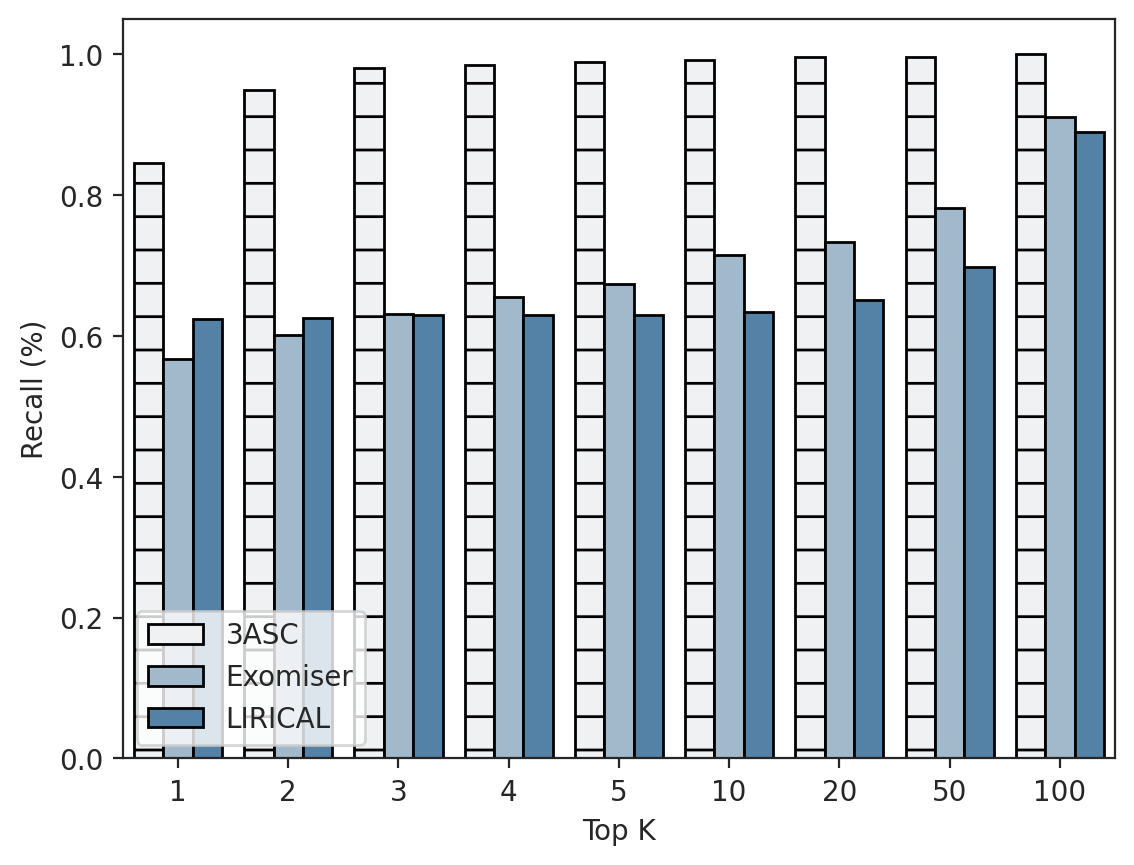

In [10]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# sns.set_context('paper')
# sns.set_color_codes('pastel')
sns.set_style("ticks")
figure_data = pd.DataFrame(
    {
        "topk": exomiser_topk.tolist() + asc3_topk.tolist() + lirical_topk.tolist(),
        "Tool": ["Exomiser"] * len(exomiser_topk) + ["3ASC"] * len(asc3_topk) + ["LIRICAL"] * len(lirical_topk),
        "rank": ks * 3,
    }
)

sns.color_palette("Paired")
legend_order = ["3ASC", "Exomiser", "LIRICAL"]
fig, axes = plt.subplots(dpi=200)
bar = sns.barplot(
    figure_data, 
    x="rank", 
    y="topk", 
    hue="Tool", 
    hue_order=legend_order,
    color="steelblue", 
    edgecolor="k", 
    ax=axes,
)

axes.set(xlabel="Top K", ylabel="Recall (%)")


# Loop over the bars
hatches = ['-', '+', 'x', '\\', '*', 'o']
for i, thisbar in enumerate(bar.patches, start=1):
    # Set a different hatch for each bar
    if i <= len(ks):
        thisbar.set_hatch("-")

    if i > len(ks):
        continue
        # thisbar.set_hatch("//")
    if i > len(ks)*2:
        continue

plt.legend(loc="lower left")
plt.savefig("results/2_9_benchmark_ar.png")

In [ ]:
Mixture: 공통적으로 변이로 올리기